# Análisis de Componentes Principales (PCA)

Lo primero que realizamos es importar las librerías necesarias, definir algunas constantes y cargar el dataset.

In [123]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils import Utils

COLORS = ["#003049", "#d62828", "#f77f00", "#fcbf49", "#eae2b7", "#007F83", "#BC3C28", "#FFD56B", "#006A4E"]

DATASET_PATH = os.path.join("resources", "europe.csv")
dataset = pd.read_csv(DATASET_PATH)

## Análisis de las variables (boxplot)

Primero, definimos una función para graficar los boxplots de las variables.

In [124]:
def show_boxplot(dataset):
    fig, ax = plt.subplots()

    boxplot = ax.boxplot(dataset.select_dtypes(include='number').values, patch_artist=True, medianprops=dict(color="white"))

    for patch, color in zip(boxplot['boxes'], COLORS):
        patch.set_facecolor(color)

    ax.set_xticklabels(dataset.columns[1:], rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

Veamos los boxplots de las variables sin ninguna estandarización.

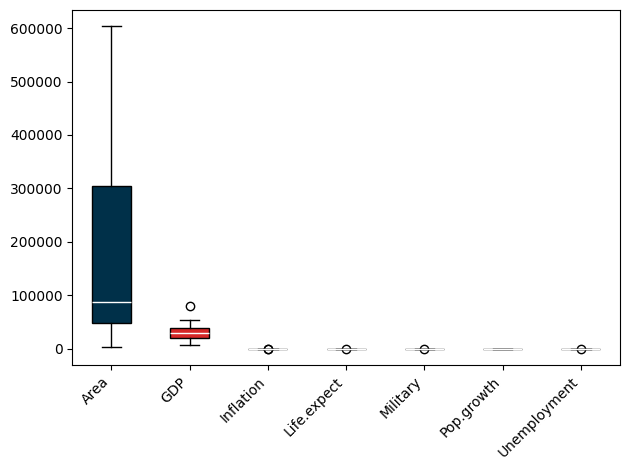

In [125]:
show_boxplot(dataset)

Como se puede apreciar, al no estar los datos estandarizados, la variable "Area" de los países es la predominante y, debido a su magnitud, no deja ver las demás variables.

Se aplica el método z-score para estandarizar los datos, y se obtiene lo siguiente:

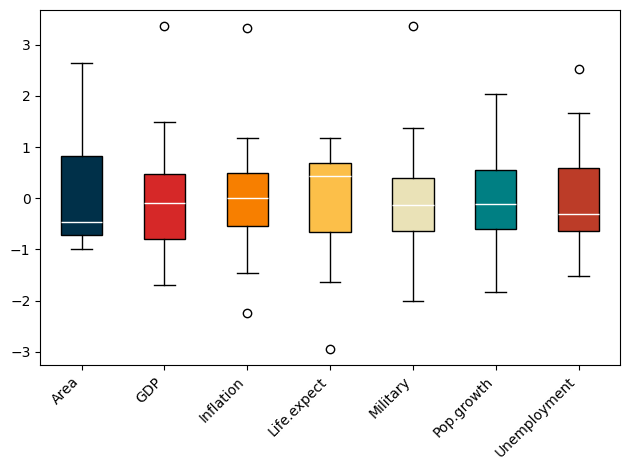

In [126]:
standarizedDataset = Utils.zScoreData(dataset)
show_boxplot(standarizedDataset)

## Análisis de Componentes Principales (PCA)

Para realizar el análisis de componentes principales, se calcula la matriz de correlaciones en lugar de la matriz de covarianzas, proque los datos ya están estandarizados:

In [127]:
sx = np.corrcoef(standarizedDataset.select_dtypes(include='number').values, rowvar=False)

A partir de esta matriz, se calculan los autovalores ordenados descendentemente:

In [128]:
evalues, evectors = np.linalg.eig(sx) 
indices = np.argsort(evalues)[::-1]
sortedEvalues = evalues[indices]
sortedEvectors = np.transpose(evectors[:, indices])

print("Autovalores:", sortedEvalues)

Autovalores: [3.22716568 1.18712341 1.06319053 0.77035598 0.45784862 0.16867389
 0.12564189]


La primer componente será entonces la combinación lineal de los componentes del autovector asociado al mayor autovalor, es decir a $\lambda = 3.22716568$.
El autovector en cuestión es:

In [129]:
print("Autovector 1:", sortedEvectors[0])
print("Autovector 2:", sortedEvectors[1])

Autovector 1: [-0.1248739   0.50050586 -0.40651815  0.48287333 -0.18811162  0.47570355
 -0.27165582]
Autovector 2: [ 0.1728722   0.13013955  0.36965724 -0.2652478  -0.65826689 -0.08262198
 -0.55320371]


El componente principal PC1 será entonces combinación lineal de estos valores:

PC1 = $-0.1248739 \cdot Area + 0.50050586 \cdot GDP - 0.40651815 \cdot Inflation + 0.48287333 \cdot Life.expect - 0.18811162 \cdot Military + 0.47570355 \cdot Pop.growth - 0.27165582 \cdot Unemployment$

### Interpretación de PC1

Como se puede observar, en PC1, la variable que más influye es el valor del producto bruto interno (GDP), seguida por la expectativa de vida, el crecimiento de a población y la inflación de manera inversa. Es decir, un alto PBI hace aumentar PC1 mientras que una alta inflación lo hace bajar. En menor medida, también influyen el área del país, el gasto militar y la tasa de desempleo.

#### PC1 y PC2 por país

           Country       PC1       PC2
0          Austria  1.062255  1.247165
1          Belgium  0.668821  0.408544
2         Bulgaria -2.562850 -0.264779
3          Croatia -1.247261 -1.867164
4   Czech Republic  0.164196  0.129566
5          Denmark  0.937979  0.402247
6          Estonia -2.442907  0.084233
7          Finland  0.206769  0.033110
8          Germany  0.581719  0.463330
9           Greece -0.982444 -3.345459
10         Hungary -1.371727  0.033614
11         Iceland  1.555182  1.450644
12         Ireland  1.776322 -0.512405
13           Italy  0.837849 -0.321892
14          Latvia -2.264505  0.663179
15       Lithuania -1.502528  0.191483
16      Luxembourg  3.415755  1.056893
17     Netherlands  1.806897  0.056198
18          Norway  2.068553  0.141369
19          Poland -1.445253 -0.071670
20        Portugal -0.517006 -1.016128
21        Slovakia -0.768857  0.169156
22        Slovenia -0.066326 -0.783298
23           Spain  0.160816 -1.131306
24          Sweden  0.869

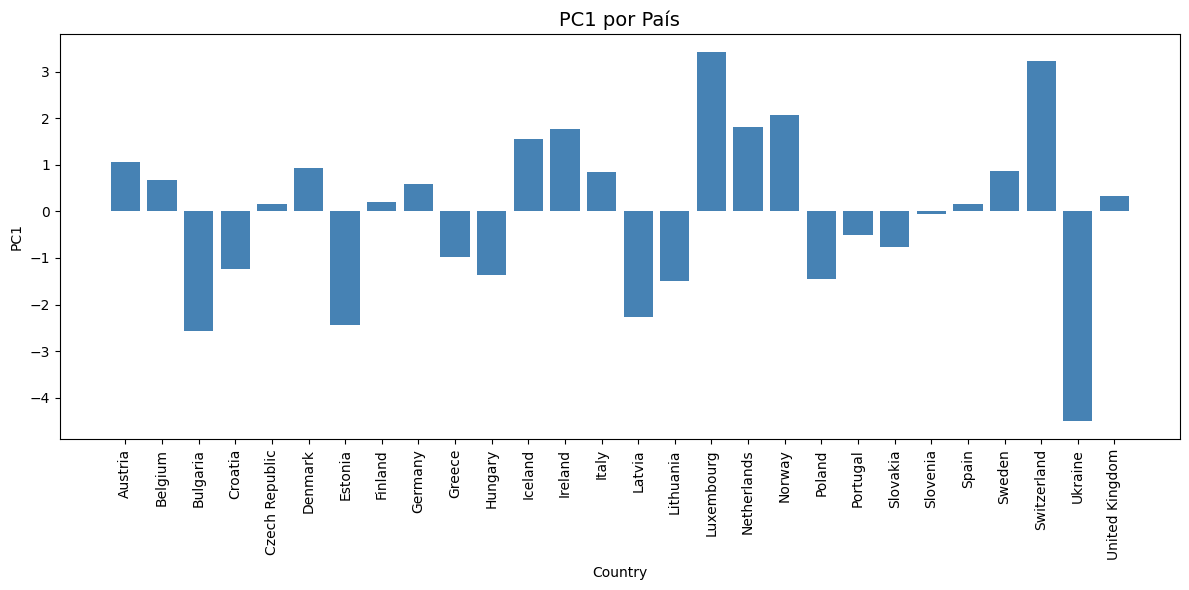

In [130]:
countries = dataset['Country']
countryData = standarizedDataset.select_dtypes(include='number').values
pcsDataset = pd.DataFrame({
    'Country': countries,
    'PC1': np.dot(countryData, sortedEvectors[0]),
    'PC2': np.dot(countryData, sortedEvectors[1]),
})
print(pcsDataset)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(countries, pcsDataset["PC1"], color='steelblue')

plt.xticks(rotation=90)

ax.set_title('PC1 por País', fontsize=14)
ax.set_xlabel('Country')
ax.set_ylabel('PC1')

plt.tight_layout()
plt.show()


### Biplot

Ahora se realiza el biplot para encontrar relaciones entre los países:

In [131]:
def biplot(dataset, datasetLabels):
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    
    ax.scatter(dataset['PC1'], dataset['PC2'], alpha=0.7, c=COLORS[1])

    for i, country in enumerate(dataset['Country']):
        ax.annotate(country, (dataset['PC1'][i], dataset['PC2'][i]), fontsize=9)

    trasposedMatrix = np.transpose([sortedEvectors[0], sortedEvectors[1]])

    vectors = np.array(trasposedMatrix)

    origin = (0, 0)
    for i, vector in enumerate(vectors):
        ax.plot((origin[0], vector[0]), (origin[1], vector[1]), color=COLORS[0], lw=1)
        ax.text(vector[0]*1.1, vector[1]*1.1, datasetLabels[i], color=COLORS[0], fontsize=9)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True)
    
    plt.show()

Luego, simplemente se llama a la función `biplot()` con los datos y los componentes principales calculados.

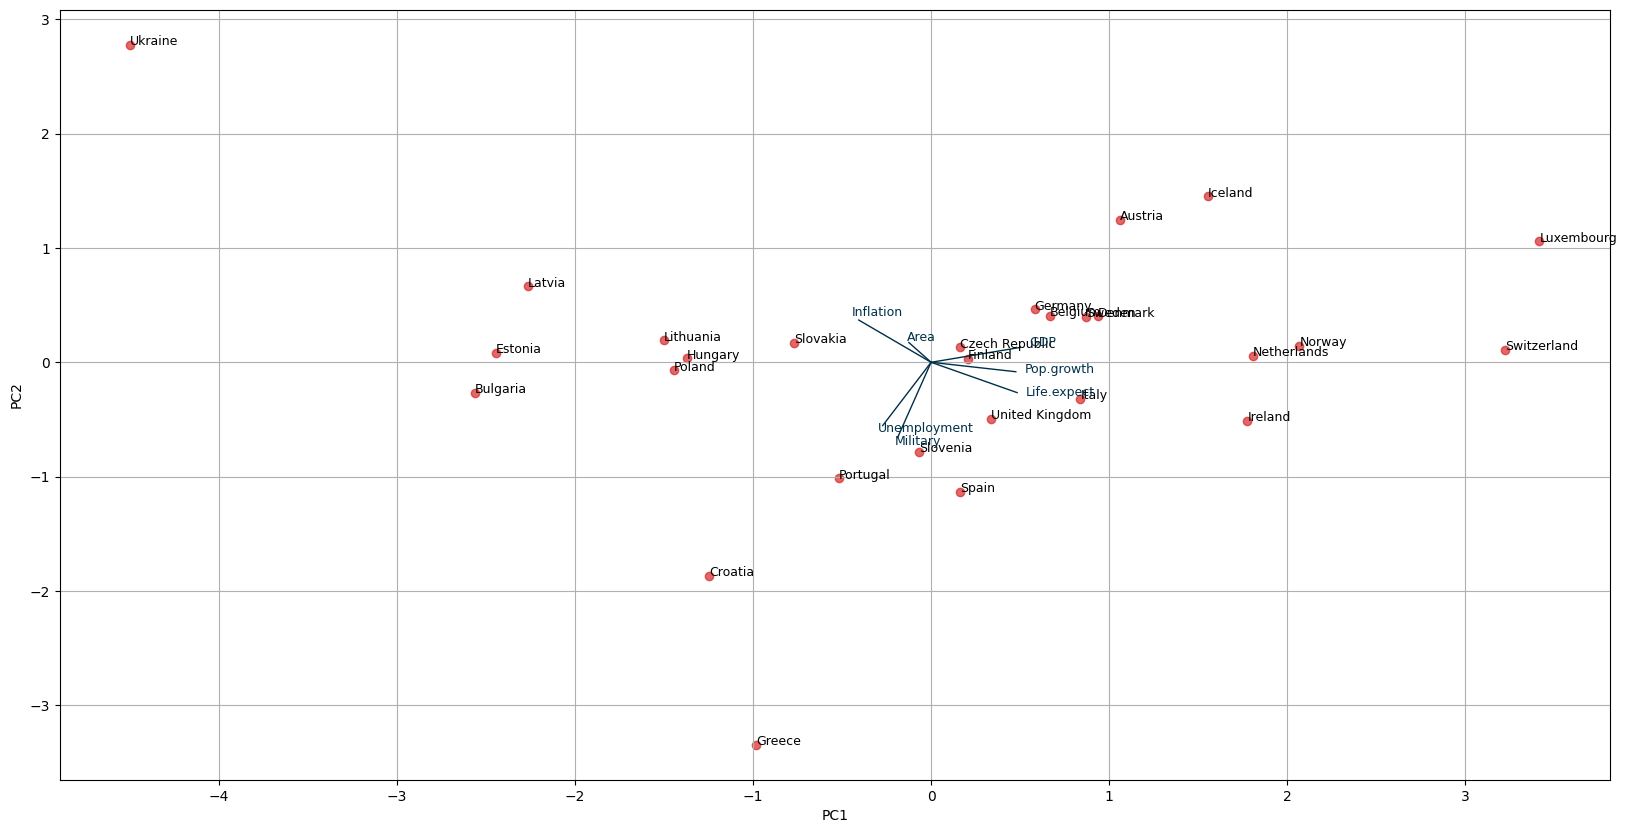

In [132]:
biplot(pcsDataset, dataset.columns[1:].to_numpy())

En base al Biplot, se puede concluir que:

* Países como Irlanda, Noruega y Países Bajos están agrupados, lo que indica condiciones económicas y sociales similares.

* Grecia, Croacia y Ucrania están más aislados, lo que sugiere que estos países difieren significativamente de los demás en cuanto a las variables consideradas.

* Países de Europa del Este como Bulgaria, Letonia y Estonia se agrupan, mostrando características similares distintas de los países de Europa Occidental.

* Ucrania es un outlier notable, ya que se sitúa lejos de los demás, lo que indica retos o condiciones económicas únicos.

* Los países cercanos a la dirección de las flechas están más influidos por esas variables. Por ejemplo: países como Alemania, Reino Unido y Francia se alinean más en el PBI y la expectiva de vida.

* La inflación parece ser un factor dominante para países como Hungría, Polonia y Lituania.

* Los países más cercanos al origen (como la República Checa, Eslovaquia y Finlandoa) tienen probablemente un perfil más equilibrado con respecto a las variables medidas.

## Análisis de Componentes Principales (PCA) con SKLearn

En vez de realizar los cálculos manualmente, se puede utilizar la librería `sklearn` para realizar el análisis de componentes principales.

In [133]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(standarizedDataset.select_dtypes(include='number').values)

PCA(n_components=2)

Luego, podemos armar un dataset similar al utilizado en el análisis manual y comparar los resultados.

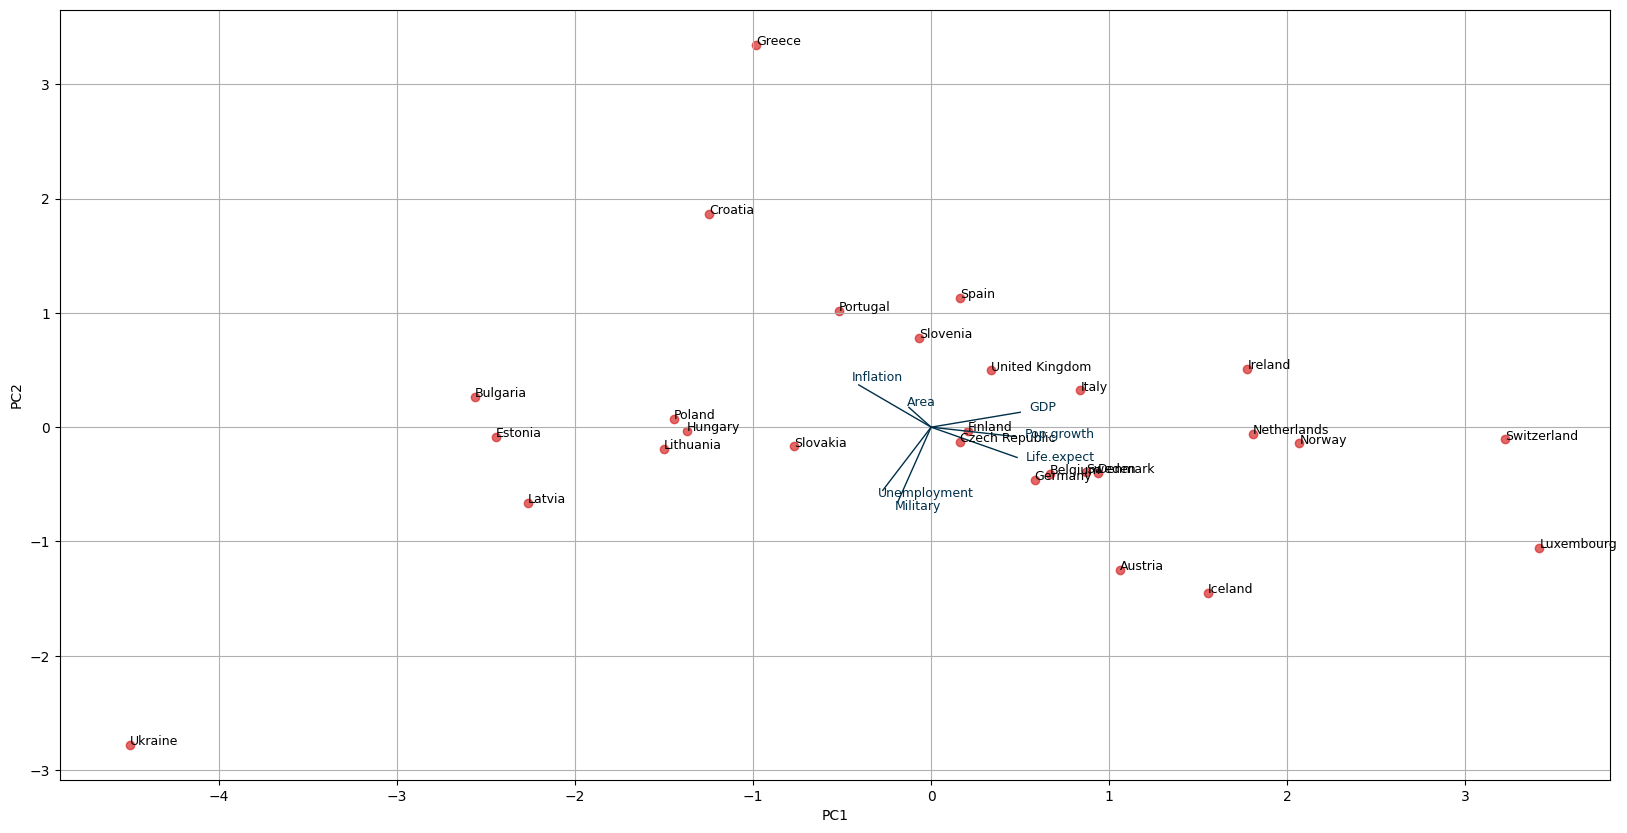

In [134]:
countries = dataset['Country']
countryData = standarizedDataset.select_dtypes(include='number').values
pcsDataset = pd.DataFrame({
    'Country': countries,
    'PC1': np.dot(countryData, pca.components_[0]),
    'PC2': np.dot(countryData, pca.components_[1]),
})

biplot(pcsDataset, dataset.columns[1:].to_numpy())

Se puede observar que se obtiene el mismo Biplot que con el análisis manual, por lo que sus conclusiones son válidas.